https://bergvca.github.io/2020/01/02/string-grouper.html

In [13]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

try:
    from sparse_dot_topn import awesome_cossim_topn
    _HAVE_SPARSE_DOT = True
except ImportError:
    _HAVE_SPARSE_DOT = False

In [14]:
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Needed to load in custom package from upper dir
# Not needed if you pip installed the package
import sys
sys.path.insert(1, '../')

# Custom packages
from polymatcher.models import EditDistance, TFIDF
from polymatcher import PolyMatch

# Reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
with open("../data/company_names.json") as outfile:
    company_names = json.load(outfile)

with open("../data/movie_titles.json") as outfile:
    movie_titles = json.load(outfile)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn
import numpy as np
from sklearn.neighbors import NearestNeighbors


def _create_ngrams(string: str):
    """ Create n_grams from a string

    Steps:
        * Extract character-level ngrams with `self.n_gram_range` (both ends inclusive)
        * Remove n-grams that have a whitespace in them
    """
    
    result = []
    for n in range(3, 4):
        ngrams = zip(*[string[i:] for i in range(n)])
        ngrams = [''.join(ngram) for ngram in ngrams if ' ' not in ngram]
        result.extend(ngrams)

    return result

# vectorizer = TfidfVectorizer(min_df=1, analyzer=_create_ngrams).fit(movie_titles["IMDB"][:5000] + movie_titles["Netflix"])
# tf_idf_to = vectorizer.transform(movie_titles["IMDB"][:5000])
# tf_idf_from = vectorizer.transform(movie_titles["Netflix"])

vectorizer = TfidfVectorizer(min_df=1, analyzer=_create_ngrams).fit(movie_titles["Netflix"] + movie_titles["Netflix"])
tf_idf_to = vectorizer.transform(movie_titles["Netflix"])
tf_idf_from = vectorizer.transform(movie_titles["IMDB"][:5000])



In [69]:
knn = NearestNeighbors(n_neighbors=2, n_jobs=-1, metric='cosine').fit(tf_idf_to)
distances, indices = knn.kneighbors(tf_idf_to)

# similarity = [round(1 - distance, 3) for distance in distances.flatten()]

In [72]:
len(distances[:, 1])

6172

In [73]:
distances.shape

(6172, 2)

In [56]:
similarity_matrix = awesome_cossim_topn(tf_idf_to, tf_idf_from.T, 2, 0.1)
similarity_matrix = similarity_matrix.tolil()
similarity_matrix.setdiag(0.)
similarity_matrix = similarity_matrix.tocsr()
# indices = np.array(similarity_matrix.argmax(axis=1).T).flatten()
# similarity = similarity_matrix.max(axis=1).toarray().T.flatten()

In [57]:
test = similarity_matrix[0].toarray()[0]

In [58]:
test.sort()

In [59]:
test

array([0.        , 0.        , 0.        , ..., 0.        , 0.44435037,
       0.52046964])

In [21]:
similarity

array([0., 0., 0., ..., 0., 0., 0.])

In [5]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=_create_ngrams).fit(company_names)
tf_idf_to = vectorizer.transform(company_names)
tf_idf_from = vectorizer.transform(company_names)

In [12]:
similarity_matrix = awesome_cossim_topn(tf_idf_to, tf_idf_from.T, 1, 0.9, use_threads=True, n_jobs=4)

In [ ]:
indices = np.array(similarity_matrix.argmax(axis=1).T).flatten()

In [ ]:
similarity = similarity_matrix.max(axis=1).toarray().T.flatten()

In [15]:
# Similarity
similarity_matrix = awesome_cossim_topn(tf_idf_to, tf_idf_to.T, 10, 0.9)
similarity_matrix = similarity_matrix.tolil()
similarity_matrix.setdiag(0.)

# # DataFrame
matches = [(row, col, similarity_matrix[row, col]) for row, col in zip(*similarity_matrix.nonzero())]
matches = pd.DataFrame(matches, columns=["From", "To", "Similarity"])
matches = matches[matches.groupby(['From'])['Similarity'].transform(max) == matches['Similarity']]
matches.From = [movie_titles["IMDB"][:5000][idx] for idx in matches.From]
matches.To = [movie_titles["IMDB"][:5000][idx] for idx in matches.To]

In [16]:
cluster_mapping = {}
cluster_id = 0

for row in matches.itertuples():
    
    # If from string has not already been mapped
    if not cluster_mapping.get(row.From):
        
        # If the to string has not already been mapped
        if not cluster_mapping.get(row.To):
            cluster_mapping[row.To] = cluster_id
            cluster_mapping[row.From] = cluster_id
            cluster_id += 1
            
        # If the to string has already been mapped
        else:
            cluster_mapping[row.From] = cluster_mapping.get(row.To)
            
# Populate the clusters
clusters = {}
for key, value in cluster_mapping.items():
    clusters.setdefault(value, [])
    clusters[value].append(key)

In [18]:
cluster_mapping

{'Fantômas': 49,
 'Fantômas contre Fantômas': 49,
 'Perils of Pauline': 1,
 'The Perils of Pauline': 1,
 'Poor Little Rich Girl': 2,
 'The Poor Little Rich Girl': 2,
 'Broadway': 3,
 'Broadway Love': 3,
 "J'accuse!": 4,
 "J'accuse": 4,
 'The New Adventures of Tarzan': 5,
 'Adventures of Tarzan': 5,
 'The Son of Monte Cristo': 6,
 'Monte Cristo': 6,
 'The Phantom': 7,
 'Phantom': 7,
 'The Saturday Night Kid': 8,
 'Saturday Night': 8,
 'Phantom of the Opera': 9,
 'The Phantom of the Opera': 9,
 'The Man from Tumbleweeds': 10,
 'Tumbleweeds': 10,
 'San Francisco': 11,
 'Old San Francisco': 11,
 'Law of the Underworld': 12,
 'Underworld': 12,
 'Her Cardboard Lover': 13,
 'The Cardboard Lover': 13,
 'At the Circus': 14,
 'The Circus': 14,
 'Docks of New York': 15,
 'The Docks of New York': 15,
 'Power of the Press': 16,
 'The Power of the Press': 16,
 'Paris Underground': 17,
 'Underground': 17,
 'Bulldog Drummond at Bay': 18,
 'Bulldog Drummond': 18,
 'Kid Dynamite': 19,
 'Dynamite': 19,
 

In [13]:
matches.From = [movie_titles["IMDB"][:5000][idx] for idx in matches.From]
matches.To = [movie_titles["IMDB"][:5000][idx] for idx in matches.To]

In [14]:
matches

,From,To,Similarity
0,Fantômas contre Fantômas,2331,0.944740
1,The Perils of Pauline,1898,0.991516
2,The Poor Little Rich Girl,2435,0.991007
3,Broadway Love,702,0.910526
4,J'accuse,3226,0.907531
...,...,...,...
131,Romeo y Julieta,2458,0.907855
132,3 Men in White,1864,1.000000
133,Docks of New York,626,0.986419
134,George White's Scandals,2068,0.905366


In [11]:
cluster_mapping

{2331: 49,
 27: 49,
 1898: 1,
 36: 1,
 2435: 2,
 100: 2,
 702: 3,
 118: 3,
 3226: 4,
 162: 4,
 2150: 5,
 230: 5,
 3608: 6,
 292: 6,
 1153: 7,
 298: 7,
 789: 8,
 302: 8,
 4448: 9,
 431: 9,
 3545: 10,
 450: 10,
 2460: 11,
 577: 11,
 2958: 12,
 604: 12,
 4061: 13,
 619: 13,
 3114: 14,
 622: 14,
 4847: 15,
 626: 15,
 4450: 16,
 660: 16,
 4936: 17,
 679: 17,
 2573: 18,
 705: 18,
 4399: 19,
 719: 19,
 1121: 20,
 745: 20,
 3256: 21,
 747: 21,
 2987: 22,
 759: 22,
 2429: 23,
 777: 23,
 987: 24,
 784: 24,
 2188: 25,
 788: 25,
 1721: 26,
 791: 26,
 4149: 27,
 804: 27,
 1784: 28,
 863: 28,
 2390: 29,
 891: 29,
 3062: 30,
 980: 30,
 4469: 31,
 1050: 31,
 3324: 32,
 1069: 32,
 2155: 33,
 1109: 33,
 2996: 34,
 1146: 34,
 3590: 35,
 1169: 35,
 2319: 36,
 1227: 36,
 2915: 37,
 1266: 37,
 4607: 38,
 1286: 38,
 2108: 39,
 1319: 39,
 1482: 3,
 3297: 40,
 1628: 40,
 2989: 41,
 1810: 41,
 4759: 42,
 1864: 42,
 2135: 43,
 1869: 43,
 4529: 44,
 1995: 44,
 4869: 45,
 2068: 45,
 2952: 46,
 2093: 46,
 3277: 47,

In [476]:
for index in clusters[3]:
    print(movie_titles["IMDB"][index])

Broadway
Broadway Love
Broadway Bad


In [444]:
# Single Linkage
test = matches[["From", "To"]].values; test
clusters = {}
cluster_val = 0
for match in test:
    if not clusters.get(match[0]):
        if not clusters.get(match[1]):
            clusters[match[0]] = cluster_val
            clusters[match[1]] = cluster_val
            cluster_val += 1
        else:
            clusters[match[0]] = clusters.get(match[1])
            cluster_val += 1
            


In [410]:
matches.loc[(matches.From==1992) | (matches.To==1992), :]

,From,To,Similarity
448,1992,697,0.722615


In [412]:
movie_titles["IMDB"][:5000][10], movie_titles["IMDB"][:5000][697], movie_titles["IMDB"][:5000][1295], movie_titles["IMDB"][:5000][1992]

('Atlantis', 'Atlantic', 'Die Herrin von Atlantis', 'Atlantic Adventure')

In [ ]:
10, 697, 1295, 1992

In [456]:
for key in cluster_mapping.keys():
    if cluster_mapping[key] == 1:
        print(key)

697
10
1295
1992


In [387]:
mappings = {}

In [388]:
matches.From = matches.From.astype(int)

In [389]:
for i in matches.values:
    mappings[int(i[0])] = int(i[1])

In [384]:
for key in mappings.keys():
    if mappings.get(mappings[key]):
        mappings[key] = mappings.get(mappings[key])
        print(mappings[key])

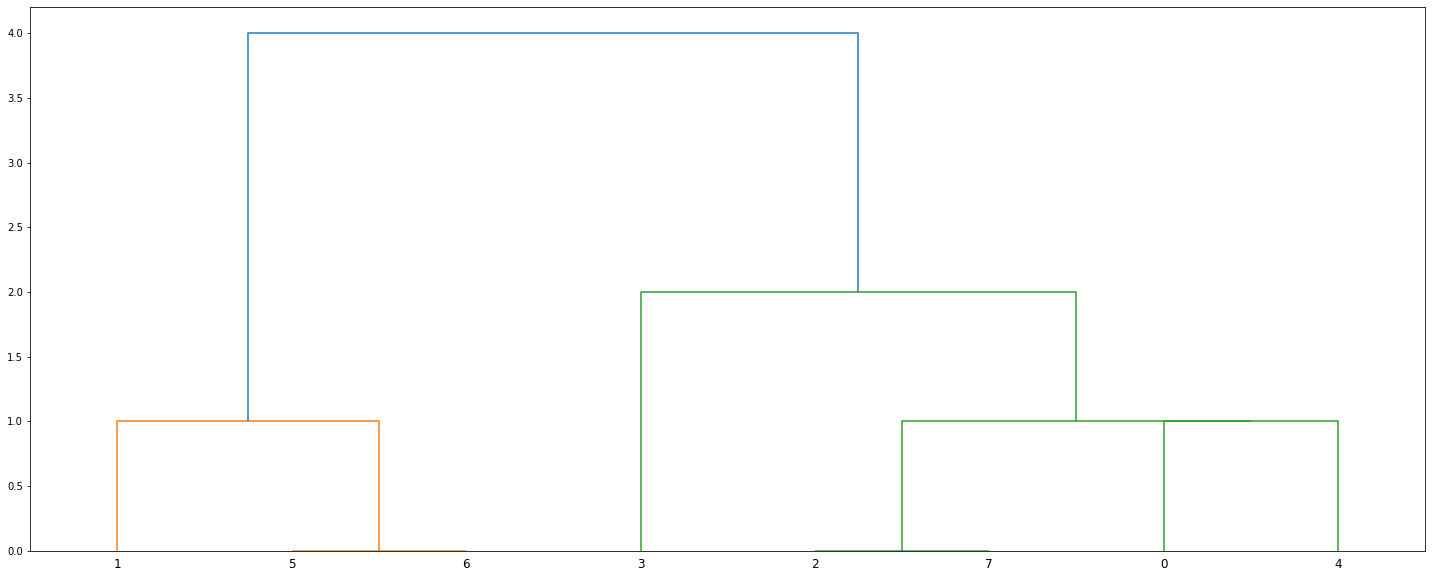

In [194]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]

Z = linkage(X, 'single')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [184]:
from tqdm import tqdm

In [186]:
for row, col in tqdm(zip(*similarity_matrix.nonzero())):
    val = similarity_matrix[row, col]

8427it [00:00, 36816.36it/s]


In [50]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import connected_components

In [98]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [110]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [106]:
clustering = AgglomerativeClustering(affinity='precomputed', linkage='single').fit(1-similarity_matrix.toarray())

In [107]:
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [108]:
counts = pd.DataFrame(clustering.labels_, columns=['Class']).Class.value_counts()

In [109]:
counts

0    4999
1       1
Name: Class, dtype: int64

In [51]:
del result

In [65]:
r = connected_components(similarity_matrix)
counts = pd.DataFrame(r[1], columns=['Class']).Class.value_counts()

In [73]:
test = counts[counts > 1]

0

In [76]:
indices = np.argwhere(r[1]==test.index[0]).T.flatten()

In [87]:
similarity_matrix_selection = similarity_matrix[:, indices][indices, :]

In [19]:
import hdbscan

In [145]:
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=1, 
                            min_cluster_size=2,
                            allow_single_cluster=True).fit(similarity_matrix_selection)

In [146]:
clusters = pd.DataFrame(clusterer.labels_, columns=['Class']).Class.value_counts(); clusters

-1    2947
 0    2044
Name: Class, dtype: int64

In [120]:
tree = clusterer.condensed_tree_.to_pandas()

In [149]:
clusters = pd.DataFrame(clusterer.single_linkage_tree_.get_clusters(0.1, min_cluster_size=1), columns=['Class']).Class.value_counts(); clusters

117    4787
203       1
93        1
85        1
81        1
       ... 
122       1
118       1
114       1
110       1
0         1
Name: Class, Length: 205, dtype: int64

In [139]:
movie_titles["IMDB"][:5000][2032], movie_titles["IMDB"][:5000][2479]

('Crime Unlimited', 'Special Investigator')

<AxesSubplot:ylabel='$\\lambda$ value'>

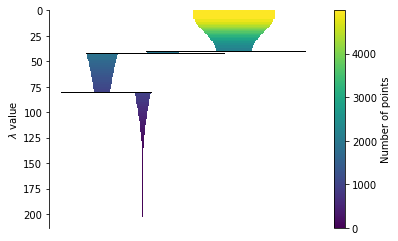

In [150]:
clusterer.condensed_tree_.plot()

In [17]:
from rapidfuzz import fuzz

models = {
          "TF-IDF-NGRAM": TFIDF(n_gram_range=(3, 5))
        }

pm = PolyMatch(models)

In [18]:
matches = pm.match(movie_titles["IMDB"][:5000], movie_titles["Netflix"])

In [19]:
matches["TF-IDF-NGRAM"]

,From,To,Similarity
0,Miss Jerry,Tom and Jerry: The Magic Ring,0.586513
1,The Story of the Kelly Gang,Story of an Egg,0.443260
2,Den sorte drøm,A Sort of Family,0.314065
3,Cleopatra,Cleopatra Jones,0.900328
4,L'Inferno,Into the Inferno,0.811386
...,...,...,...
4995,Two O'Clock Courage,Brené Brown: The Call to Courage,0.502447
4996,The Unseen,Have You Seen the Listers?,0.233848
4997,Unter den Brücken,Hunter X Hunter (2011),0.333121
4998,Utah,Tattah,0.191648


In [3]:
from rapidfuzz import fuzz

models = {
          "EditDistance": EditDistance(n_jobs=-1, score_cutoff=0.5, scorer=fuzz.ratio),
          "TF-IDF": TFIDF(n_gram_range=(3, 3), use_knn=True),
          "TF-IDF-NGRAM": TFIDF(n_gram_range=(3, 5))
        }

pm = PolyMatch(models)

In [8]:
matches = pm.match(movie_titles["IMDB"][:5000], movie_titles["Netflix"])

In [5]:
min_precision, recall, avg_precision = pm.precision_recall_curve()

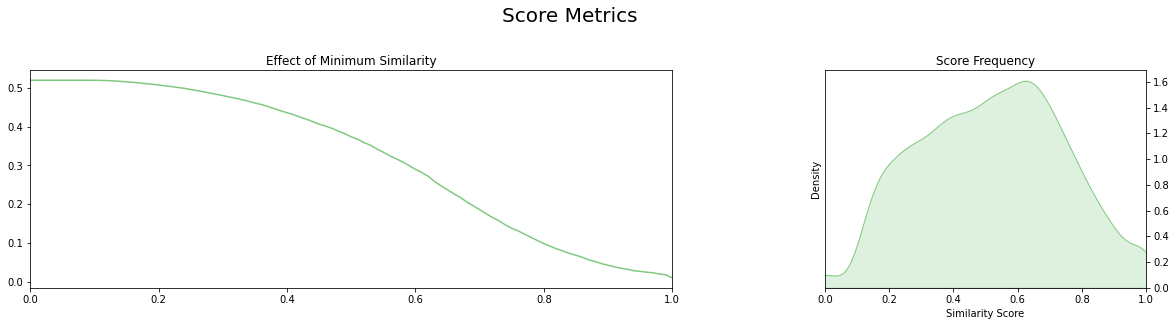

In [6]:
pm.visualize_precision_recall()

# Edit distance

In [3]:
ed = EditDistance(n_jobs=-1, score_cutoff=0.5)
result = ed.match(movie_titles["Netflix"][:1000], movie_titles["IMDB"][:1000])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.91it/s]


In [4]:
result.head()

,From,To,Similarity
0,Norm of the North: King Sized Adventure,The Bargain,0.855
1,Jandino: Whatever it Takes,It's a Great Life,0.855
2,Transformers Prime,The Informer,0.600
3,Transformers: Robots in Disguise,Traffic in Souls,0.855
4,#realityhigh,It,0.900


# TF-IDF

In [20]:
tfidf = TFIDF(n_gram_range=(3, 3))
matches = tfidf.match(movie_titles["Netflix"], movie_titles["IMDB"][:1000])